In [146]:
import pandas as pd
import numpy as np
from src import format
import string
from src.model import ChurnModel
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from src import model as m
from src.clusters import KMeans
from src.ensemble import EnsembleChurnModel

In [147]:
import matplotlib
matplotlib.use("TkAgg")
from matplotlib import pyplot as plt
%matplotlib inline

In [148]:
path = '../club_members.csv'
clubs = pd.read_csv(path)

path = '../customer_list.csv'
customers = pd.read_csv(path)

path = '../order_history.csv'
data = pd.read_csv(path)

In [149]:
customers.columns

Index(['Customer No.', 'City', 'State', 'Zip Code', 'Number Of Transactions', 'Lifetime Value', 'Last Order Date', 'Last Order Amount', 'Date Added', 'Last Modified Date'], dtype='object')

In [150]:
customers["Customer No."].describe()

count    32820.000000
mean     21582.832602
std       9630.512373
min       1001.000000
25%      13238.750000
50%      21539.500000
75%      29861.250000
max      38339.000000
Name: Customer No., dtype: float64

In [151]:
clubs['Customer Number'].describe()

count     4366.000000
mean     22693.969766
std       8208.199784
min       5010.000000
25%      16671.750000
50%      22324.500000
75%      28246.250000
max      38337.000000
Name: Customer Number, dtype: float64

In [152]:
customers.sample(10)

,Customer No.,City,State,Zip Code,Number Of Transactions,Lifetime Value,Last Order Date,Last Order Amount,Date Added,Last Modified Date
15754,20877,NaN,NaN,NaN,1.0,$129.30,5/16/17,$129.30,5/16/17,5/16/17
23880,29125,NaN,NaN,NaN,0.0,$0.00,NaN,$0.00,7/13/18,7/13/18
22508,27722,NaN,NaN,NaN,0.0,$0.00,NaN,$0.00,5/23/18,5/23/18
6802,11822,NaN,NaN,NaN,1.0,$70.20,7/24/15,$70.20,7/24/15,7/24/15
20793,25994,NaN,NaN,NaN,1.0,$207.19,4/26/18,$207.19,4/26/18,4/26/18
16185,21312,NaN,NaN,NaN,1.0,$25.00,6/19/17,$25.00,6/19/17,6/19/17
4268,9277,Calistoga,CA,94515,1.0,$51.84,1/7/15,$51.84,1/7/15,1/7/15
11472,16543,NaN,NaN,89503,1.0,$32.40,6/29/16,$32.40,6/29/16,6/29/16
18451,23619,NaN,NaN,NaN,0.0,$0.00,NaN,$0.00,12/5/17,12/5/17
14605,19713,marina del rey,CA,90292,4.0,$244.90,5/21/17,$244.90,2/25/17,5/21/17


In [153]:
data = data.sort_values("Customer Number")

In [154]:
data.head(100)

,OrderNumber,Customer Number,OrderCompletedDate,orderstatus,ordertype,BillCustomerNumber,ShipStateCode,BillBirthDate,ShipZipCode,BillCity,BillZipCode,isPickup,Quantity,ProductType,ProductSKU,originalPrice,Price
0,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,1,Wine,44.15.750.TK.RB.TE,45.0,31.5
1,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,1,Product,CL.HT.3200.BK,20.0,14.0
2,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,2,Wine,47.15.750.TK.RB.LYS,50.0,35.0
3,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,5,Product,TK.GC,0.0,0.0
4,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,2,Wine,44.14.750.TK.CS.RB,55.0,38.5
5,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,4,Product,TK.GCIN,0.0,0.0
107,47319,5002,2017-08-14 18:02:18,Completed,Promo,5002.0,CA,1920-01-01,94109,Calistoga,94515,False,2,Wine,42.15.750.TK.RB.GTT,65.0,0.0
108,47319,5002,2017-08-14 18:02:18,Completed,Promo,5002.0,CA,1920-01-01,94109,Calistoga,94515,False,2,Wine,12.14.750.TK.RB.HEAVY,65.0,0.0
109,47319,5002,2017-08-14 18:02:18,Completed,Promo,5002.0,CA,1920-01-01,94109,Calistoga,94515,False,2,Wine,24.14.750.TK.RB.JO,55.0,0.0
110,47272,5002,2017-08-13 12:07:33,Completed,Promo,5002.0,CA,1920-01-01,94515,Calistoga,94515,True,1,Product,CL.TS.M.1008.HG.XL,30.0,0.0


In [155]:
data["ordertype"].unique()

array(['POS', 'Promo', 'AdminPanel', 'Phone', 'Event', 'ClubDaily',
       'Website', 'Reservation', 'ClubOrder', 'Corporate', 'ClubOnsite',
       'Marketplace', 'Mobile'], dtype=object)

In [156]:
data["ordertype"].unique()

array(['POS', 'Promo', 'AdminPanel', 'Phone', 'Event', 'ClubDaily',
       'Website', 'Reservation', 'ClubOrder', 'Corporate', 'ClubOnsite',
       'Marketplace', 'Mobile'], dtype=object)

In [157]:
data[data["ProductType"]=="Bundle"]["Price"].count()

1634

In [158]:
data[data["ordertype"]=='ClubOnsite']["Price"].sum()

3848.3

In [159]:
data[data["Quantity"].isna()]

,OrderNumber,Customer Number,OrderCompletedDate,orderstatus,ordertype,BillCustomerNumber,ShipStateCode,BillBirthDate,ShipZipCode,BillCity,BillZipCode,isPickup,Quantity,ProductType,ProductSKU,originalPrice,Price


In [160]:
data.columns

Index(['OrderNumber', 'Customer Number', 'OrderCompletedDate', 'orderstatus', 'ordertype', 'BillCustomerNumber', 'ShipStateCode', 'BillBirthDate', 'ShipZipCode', 'BillCity', 'BillZipCode', 'isPickup', 'Quantity', 'ProductType', 'ProductSKU', 'originalPrice', 'Price'], dtype='object')

In [161]:
import csv
import random
import pickle

In [162]:
clubs = format.clean_data()
format.get_test_train_set(clubs)

In [163]:
clubs_train = pd.read_csv('../train_set.csv')
clubs_test = pd.read_csv('../test_set.csv')

In [164]:
cols = ['Age','ASP','Quarter Case','isPickup','Time Since Last Order','Orders Total','Last Order Amount']


In [165]:
cm = ChurnModel(cols)

**Taking the log of prices had a +.02 accuracy impact on boosted model**

**Trying log of Last Order Amount**

In [166]:
cm.fit_a_model(clubs_train)

/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [167]:
m.get_pickle(cm)
cm_test = pickle.load(open('model.p','rb'))

In [168]:
yhat,probas,score,cv_scores = cm_test.get_predictions(clubs_test,clubs_train)

/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-package

In [169]:
score

0.7312661498708011

In [170]:
cv_scores

array([0.7639485 , 0.7639485 , 0.76217765, 0.74605452, 0.7661406 ])

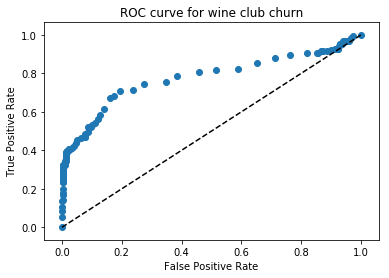

In [171]:
auc = cm_test.get_roc_curve(probas[:,1])

In [172]:
auc[0]

0.7800743716410619

**Next, do same with RF**

In [173]:
cm.fit_random_forest(clubs_train)
m.get_pickle(cm)
cm_test = pickle.load(open('model.p','rb'))

/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [174]:
yhat,probas,score,cv_scores = cm_test.get_predictions(clubs_test,clubs_train)

In [175]:
cv_scores

array([0.88412017, 0.90701001, 0.89111748, 0.88091822, 0.91248207])

In [176]:
score

0.8811369509043928

**Next, do same with GradientBoostingClassifier**

In [177]:
cols = ['Age','ASP','Quarter Case','isPickup','Time Since Last Order','Orders Total','Last Order Amount']


In [178]:
dropcols = ['Club Tier','Cancel Reason','Customer ID','State', 'Zip','Club Status','Above Mean Club Length']


In [179]:
cols_gd = list(set(list(clubs_train.columns)) - set(dropcols))

In [180]:
cols_gd

['Orders Total',
 'LTV',
 'Club Length',
 'Transactions',
 'ASP',
 'Shipments',
 'isPickup',
 'Half Case',
 'Quantity',
 'Full Case',
 'Last Order Amount',
 'Quarter Case',
 'Time Since Last Order',
 'Target',
 'Age',
 'Average Transaction']

In [181]:
cm = ChurnModel(cols)

In [182]:
clubs_train_gd = clubs_train.drop(dropcols,axis=1)
clubs_test_gd = clubs_test.drop(dropcols,axis=1)

In [183]:
cm.fit_gradient_boosted_forest(clubs_train_gd,n_estimators=100)
m.get_pickle(cm)
cm_test = pickle.load(open('model.p','rb'))

In [184]:
yhat,probas,score,cv_scores = cm_test.get_predictions(clubs_test_gd,clubs_train_gd)

In [185]:
yhat

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,

In [186]:
cv_scores

array([0.90701001, 0.90414878, 0.89111748, 0.87661406, 0.89813486])

In [187]:
score

0.8837209302325582

**Partial Dependence Plots**

In [188]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [189]:
type(cm.model)


sklearn.ensemble.gradient_boosting.GradientBoostingClassifier

In [190]:
c = np.array(clubs_train_gd.columns).reshape(-1,1).T

In [191]:
c

array([['Age', 'isPickup', 'Transactions', 'Shipments', 'Quantity',
        'Orders Total', 'ASP', 'LTV', 'Time Since Last Order',
        'Last Order Amount', 'Club Length', 'Average Transaction',
        'Target', 'Quarter Case', 'Half Case', 'Full Case']], dtype=object)

In [192]:
features = []
for col in cols:
    features.append(np.argwhere(c==col)[0])
    

features = list(np.array(features)[:,1])

In [193]:
clubs_train_gd.head()

,Age,isPickup,Transactions,Shipments,Quantity,Orders Total,ASP,LTV,Time Since Last Order,Last Order Amount,Club Length,Average Transaction,Target,Quarter Case,Half Case,Full Case
0,29.0,True,7.0,2,0.0,0.0,0.0,570.98,0.000000,58.19,1.416667,81.568571,False,1,0,0
1,65.0,True,28.0,8,0.0,0.0,0.0,4831.37,0.000000,309.21,3.250000,172.548929,False,0,1,0
2,36.0,False,2.0,0,0.0,0.0,0.0,148.50,0.000000,0.00,0.083333,74.250000,False,1,0,0
3,119.0,False,3.0,3,0.0,0.0,0.0,320.90,0.083333,138.66,1.333333,106.966667,True,1,0,0
4,37.0,False,6.0,2,0.0,0.0,0.0,586.00,0.000000,172.44,1.416667,97.666667,False,1,0,0


In [194]:
c = list(clubs_train_gd[cols].columns)

In [195]:
c

['Age',
 'ASP',
 'Quarter Case',
 'isPickup',
 'Time Since Last Order',
 'Orders Total',
 'Last Order Amount']

In [196]:
# Hard-coding in order to test
features = np.arange(0,len(c))
features

array([0, 1, 2, 3, 4, 5, 6])

**Partial Dependence Plots are a huge plus for interpretability**

Need to adjust time since last order gto include POS data on


Club member attrition appears to be maximal within first 9 months

More transactions churn less (ASP)

Pickups churn less

Bigger spenders churn less



Text(0.5, 1.0, 'Partial Dependence Plots for Gradient Boosted Model')

<Figure size 432x288 with 0 Axes>

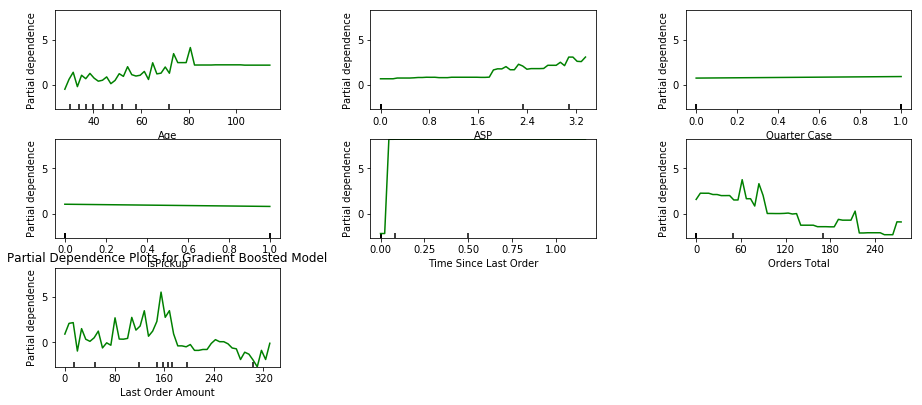

In [197]:
fig = plt.figure()
fig , axs = plot_partial_dependence(cm.model, clubs_train_gd[cols].values, features,
                                   feature_names=clubs_train_gd[cols].columns,
                                   n_jobs=3, grid_resolution=50,figsize=(14,9))
plt.title("Partial Dependence Plots for Gradient Boosted Model")

In [198]:
type(fig)

matplotlib.figure.Figure

**Now we'll get into k-means clustering**

In [199]:
clubs_train.head()

,Customer ID,Club Tier,State,Zip,Age,isPickup,Transactions,Shipments,Quantity,Orders Total,ASP,LTV,Time Since Last Order,Last Order Amount,Club Status,Club Length,Cancel Reason,Average Transaction,Above Mean Club Length,Target,Quarter Case,Half Case,Full Case
0,33861,3-Bottle,CA,95407,29.0,True,7.0,2,0.0,0.0,0.0,570.98,0.000000,58.19,Active,1.416667,NaN,81.568571,0,False,1,0,0
1,18858,6-Bottle,CA,95952,65.0,True,28.0,8,0.0,0.0,0.0,4831.37,0.000000,309.21,Active,3.250000,NaN,172.548929,1,False,0,1,0
2,36283,3-Bottle,MO,63017,36.0,False,2.0,0,0.0,0.0,0.0,148.50,0.000000,0.00,Active,0.083333,NaN,74.250000,0,False,1,0,0
3,23382,3-Bottle,CA,94518,119.0,False,3.0,3,0.0,0.0,0.0,320.90,0.083333,138.66,Cancelled,1.333333,NaN,106.966667,0,True,1,0,0
4,33856,3-Bottle,CA,95683,37.0,False,6.0,2,0.0,0.0,0.0,586.00,0.000000,172.44,Active,1.416667,NaN,97.666667,0,False,1,0,0


In [200]:
clubs_train[clubs_train["Time Since Last Order"]<0]

,Customer ID,Club Tier,State,Zip,Age,isPickup,Transactions,Shipments,Quantity,Orders Total,ASP,LTV,Time Since Last Order,Last Order Amount,Club Status,Club Length,Cancel Reason,Average Transaction,Above Mean Club Length,Target,Quarter Case,Half Case,Full Case
103,9547,3-Bottle,CA,94062,44.000000,True,14.0,4,3.0,10.917461,3.639154,1200.58,-0.083333,148.61,Cancelled,0.833333,No Reason Given,85.755714,0,True,1,0,0
104,11227,3-Bottle,TX,78701,114.000000,False,9.0,4,26.0,32.514538,1.250559,735.82,-1.583333,64.11,Cancelled,1.750000,Cutting Expenses/Lost Job,81.757778,1,True,1,0,0
140,8765,3-Bottle,IL,60022,51.000000,False,3.0,1,15.0,23.472138,1.564809,1449.38,-0.750000,333.63,Cancelled,1.416667,NaN,483.126667,0,True,1,0,0
217,7739,3-Bottle,NJ,8690,61.000000,False,5.0,2,3.0,3.144152,1.048051,490.94,-1.666667,25.00,Cancelled,0.333333,Shipping Prices Too High,98.188000,0,True,1,0,0
255,20145,3-Bottle,IN,47112,42.000000,False,7.0,4,0.0,0.000000,0.000000,893.25,-0.916667,93.36,Cancelled,1.916667,Too Much Wine,127.607143,1,True,1,0,0
273,11728,6-Bottle,CO,80205,43.000000,False,10.0,5,24.0,75.526709,3.146946,1400.33,-2.250000,0.00,Cancelled,1.416667,No Reason Given,140.033000,0,True,0,1,0
284,33622,3-Bottle,CA,92694,43.000000,True,7.0,1,0.0,0.000000,0.000000,321.28,-1.000000,0.00,Cancelled,0.333333,Too Much Wine,45.897143,0,True,1,0,0
401,13506,3-Bottle,CA,95132,60.000000,False,8.0,4,14.0,53.227863,3.801990,974.22,-1.083333,129.70,Cancelled,1.000000,Too Much Wine,121.777500,0,True,1,0,0
454,24141,3-Bottle,CA,94134,47.000000,True,11.0,3,0.0,0.000000,0.000000,781.64,-0.333333,36.64,Cancelled,0.833333,No Reason Given,71.058182,0,True,1,0,0
492,23511,3-Bottle,MD,21723,37.000000,False,11.0,5,0.0,0.000000,0.000000,1769.34,-0.333333,252.86,Cancelled,1.916667,NaN,160.849091,1,True,1,0,0


In [201]:
cols = ['Age','ASP','Quarter Case','isPickup','Time Since Last Order','Orders Total','Last Order Amount']


In [202]:
cluster_cols = ["Customer ID","Target"]+cols

In [203]:
cols

['Age',
 'ASP',
 'Quarter Case',
 'isPickup',
 'Time Since Last Order',
 'Orders Total',
 'Last Order Amount']

In [204]:
cluster_df = clubs_train[cluster_cols].reset_index()
cluster_df_test = clubs_test[cluster_cols].reset_index()

In [205]:
# X = cluster_df[cluster_cols].values

In [206]:
cluster_df.head()

,index,Customer ID,Target,Age,ASP,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
0,0,33861,False,29.0,0.0,1,True,0.000000,0.0,58.19
1,1,18858,False,65.0,0.0,0,True,0.000000,0.0,309.21
2,2,36283,False,36.0,0.0,1,False,0.000000,0.0,0.00
3,3,23382,True,119.0,0.0,1,False,0.083333,0.0,138.66
4,4,33856,False,37.0,0.0,1,False,0.000000,0.0,172.44


In [207]:
cluster_df.columns

Index(['index', 'Customer ID', 'Target', 'Age', 'ASP', 'Quarter Case', 'isPickup', 'Time Since Last Order', 'Orders Total', 'Last Order Amount'], dtype='object')

In [208]:
cols

['Age',
 'ASP',
 'Quarter Case',
 'isPickup',
 'Time Since Last Order',
 'Orders Total',
 'Last Order Amount']

In [209]:
cluster_df[cols].values

array([[29.0, 0.0, 1, ..., 0.0, 0.0, 58.19],
       [65.0, 0.0, 0, ..., 0.0, 0.0, 309.21],
       [36.0, 0.0, 1, ..., 0.0, 0.0, 0.0],
       ...,
       [42.0, 0.0, 1, ..., 0.0, 0.0, 113.9],
       [41.0, 0.0, 1, ..., 0.0, 0.0, 164.72],
       [32.0, 0.0, 1, ..., 0.0, 0.0, 239.0]], dtype=object)

In [210]:
km = KMeans(cluster_df,cols)

In [211]:
km.fit(min_converge=1,max_iter=4) # min_converge=1, max_iter=4

In [212]:
# Fit ensemble models

In [213]:
km.centers

[array([5.34137528e+01, 3.03312267e+00, 5.61872910e-01, 1.80602007e-01,
        3.31661093e-02, 3.46729037e+02, 2.22928161e+02]),
 array([4.99757436e+01, 5.42060525e-01, 9.47463768e-01, 1.04468599e-01,
        1.60929952e-01, 1.47836779e+01, 1.64631926e+02]),
 array([46.29455928,  0.16591954,  0.80300501,  0.6360601 ,  0.09557596,
         2.3206035 , 12.89083472]),
 array([49.71927353,  0.23238797,  0.88023952,  0.48802395,  0.13597804,
         4.12354407, 93.30946108]),
 array([5.83934957e+01, 2.53497070e+00, 8.71621622e-01, 6.41891892e-01,
        3.94144144e-02, 1.50221897e+02, 5.21679730e+01]),
 array([5.03226315e+01, 3.02506118e-01, 1.34361233e-01, 9.47136564e-02,
        1.40602056e-01, 8.80730256e+00, 3.58075507e+02])]

In [214]:
keys = np.array([2,4])

In [215]:
keys.shape

(2,)

In [216]:
cluster_df_test["Target"].iloc[keys].values

array([False, False])

In [217]:
cluster_df_test[km.columns].shape

(387, 7)

In [218]:
km.assign_test_clusters(cluster_df_test)

In [70]:
# def get_clusters():
clusters = []
targets = []
for i in range(km.k):
    mask = np.argwhere(km.y==i).ravel()
#     print(mask)
    members = cluster_df[cluster_cols].iloc[mask,:]
#     print(mask)
#     members = cluster_df.values[mask,:]
    members_targets = clubs_train["Target"].values[mask]
    cluster = pd.DataFrame(data=members,columns=cluster_cols,index=mask)
    cluster_target = pd.DataFrame(data=members_targets,columns=["Target"],index=mask)
    print(cluster.tail())
    clusters.append(cluster)
    targets.append(cluster_target)

      Customer ID  Target    Age       ASP  Club Length  Quarter Case  isPickup  Time Since Last Order  Orders Total  Last Order Amount
3360        16985   False   45.0  2.005857     2.833333             1      True                    0.0    172.503665              43.64
3391        11760   False   35.0  3.351361     4.666667             1     False                    0.0    157.513956             162.00
3408        11288   False  114.0  2.074806     3.416667             1      True                    0.0    215.779818              18.00
3411        16908   False   49.0  2.394790     2.083333             1     False                    0.0    215.531070              53.34
3445         8870   False   36.0  2.541522     3.333333             0      True                    0.0    121.993043              14.00
      Customer ID  Target    Age       ASP  Club Length  Quarter Case  isPickup  Time Since Last Order  Orders Total  Last Order Amount
3470        28223    True   36.0  0.000000     0

In [51]:
targets[5]["Target"].shape

(417,)

In [52]:
targets[5]["Target"].sum()

37

In [53]:
clusters[0].describe()

,Customer ID,Age,ASP,Club Length,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
count,1100,1100.0,1100.0,1100.0,1100,1100,1100.0,1100.0,1100.00
unique,1100,57.0,48.0,58.0,2,2,32.0,48.0,496.00
top,20477,114.0,0.0,2.5,1,False,0.0,0.0,172.44
freq,1,103.0,1053.0,62.0,888,839,715.0,1053.0,73.00


In [54]:
clusters[1].describe()

,Customer ID,Age,ASP,Club Length,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
count,559,559.0,559.0,559.00,559,559,559.0,559.0,559.00
unique,558,53.0,1.0,30.00,2,2,18.0,1.0,290.00
top,25799,32.0,0.0,1.75,1,False,0.0,0.0,172.44
freq,2,29.0,559.0,65.00,423,425,418.0,559.0,46.00


In [55]:
clusters[2].describe()

,Customer ID,Age,ASP,Club Length,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
count,86,86.0,86.0,86.0,86,86,86.0,86.0,86.0
unique,86,35.0,1.0,2.0,2,2,1.0,1.0,29.0
top,37986,29.0,0.0,0.0,1,False,0.0,0.0,0.0
freq,1,10.0,86.0,77.0,69,44,86.0,86.0,58.0


In [56]:
clusters[3].describe()

,Customer ID,Age,ASP,Club Length,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
count,947,947.0,947.0,947.00,947,947,947.0,947.0,947.0
unique,947,63.0,782.0,83.00,2,2,51.0,778.0,434.0
top,16378,114.0,0.0,3.75,1,False,0.0,0.0,0.0
freq,1,122.0,108.0,31.00,720,696,521.0,108.0,60.0


In [57]:
clusters[4].describe()

,Customer ID,Age,ASP,Club Length,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
count,381,381.0,381.0,381.0,381,381,381.0,381.0,381.0
unique,381,53.0,1.0,14.0,2,2,11.0,1.0,208.0
top,32880,30.0,0.0,1.5,1,False,0.0,0.0,0.0
freq,1,19.0,381.0,108.0,290,276,309.0,381.0,44.0


In [58]:
clusters[5].describe()

,Customer ID,Age,ASP,Club Length,Quarter Case,isPickup,Time Since Last Order,Orders Total,Last Order Amount
count,417,417.0,417.0,417.000000,417,417,417.0,417.0,417.0
unique,417,51.0,1.0,8.000000,2,2,7.0,1.0,196.0
top,34814,34.0,0.0,1.333333,1,False,0.0,0.0,0.0
freq,1,21.0,417.0,104.000000,306,294,401.0,417.0,84.0


In [59]:
e = EnsembleChurnModel(cols,clusters,targets)

In [60]:
e.fit_models()

/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/philsalazar/Galvanize/wine-clubs/wine-clubs/src/ensemble.py:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using 

In [51]:
f = 7

**Standard Deviation of Cluster**

In [52]:
df_vars = []
for df in clusters:
    stats = []
    for col in df.columns:
        stats.append(np.sqrt(df[col].var()))
    df_vars.append(stats)
df_vars = np.array(df_vars)
df_vars[:,f]

array([127.90905316,  54.40818239,  24.35133675,  47.60645662,
        19.19477016,  79.96620047])

**Mean of Cluster**

In [53]:
df_means = []
for df in clusters:
    stats = []
    for col in df.columns:
        stats.append((df[col].mean()))
    df_means.append(stats)
df_means = np.array(df_means)
df_means[:,f]

array([548.40078571, 194.62552941, 115.72436559, 137.62887719,
        16.78426273, 219.64277778])

**Means, STD of Data**

In [54]:
df_stats = []
for col in df.columns:
    stats = ("Mean: "+str(clubs_train[col].mean())+"Std: "+str(clubs_train[col].std()))
    df_stats.append(stats)
df_stats[f]

'Mean: 157.95832378223497Std: 120.3158084808101'

**Ensemble models for individual clusters**

In [59]:
# int(np.sqrt(np.array(membership).var())) # show if clustering balance is improving

**Prioritize cluster balance or convergence accuracy? Risk of overfitting?**

In [55]:
km.y.shape

(3490,)

**Check elbow curve to determine appropriate K given SSE plot**

In [56]:
k_range = np.arange(2,12)

In [57]:
sses = []
for k in k_range:
    km = KMeans(X,k=k)
    km.fit(min_converge=0.005,max_iter=10)
    sses.append(km.sse())
print(sses)

[349435.43330126704, 302666.866374794, 234896.71570299563, 192390.06491421504, 192738.88079818492, 177330.18105621354, 148450.75917520007, 141324.16942656355, 135622.8365098296, 150079.33626055438]


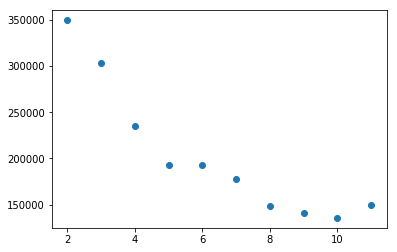

In [58]:
plt.scatter(k_range,np.array(sses))

**We'll say the elbow is at k=4**

**Apply y filter to dataframe, check .describe() . to understand why clustered together**

**Fit a model**

**Best Model LogReg**

columns
auc

cols = 'ASP','Club Length'
score = 0.73

cols = ['Age','ASP','Club Length']
score = 0.75

cols = ['Age','ASP','Club Length','Quarter Case']
score = 0.76


Lasso


cols = ['Age','ASP','Club Length','Quarter Case','isPickup','Time Since Last Order','Last Order Amount']
score = 0.85

**Not significant**


Average Transaction


Last Order Amount


**Significant**

Age

ASP

Club Length

Quarter Case

isPickup

Time Since Last Order

Last Order Amount

In [8]:
cm = ChurnModel()

**Frequeny of transacgtions**


In [10]:
print(params)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [11]:
coefs

array([[ 1.34995513e-02,  1.08757542e-01, -9.24450638e-01,
         1.82919123e-01,  7.14788344e-02,  3.30685916e+00,
        -9.79820661e-04,  4.33878729e-05]])

In [12]:
cv_scores

array([0.76972625, 0.76451613, 0.74354839, 0.76129032, 0.76935484])

**Plot ROC, get AUC score**

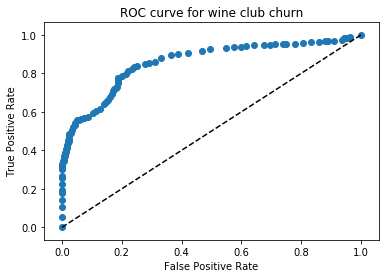

In [14]:
auc

(0.8583862317118708,
 array([1.        , 0.98791541, 0.98489426, 0.98489426, 0.98187311,
        0.97583082, 0.96978852, 0.96978852, 0.96676737, 0.96374622,
        0.96374622, 0.95770393, 0.95166163, 0.95166163, 0.95166163,
        0.95166163, 0.94561934, 0.94561934, 0.94561934, 0.94259819,
        0.93655589, 0.93655589, 0.9305136 , 0.92749245, 0.91540785,
        0.90634441, 0.90030211, 0.89425982, 0.88217523, 0.86102719,
        0.85498489, 0.8489426 , 0.83987915, 0.83383686, 0.82477341,
        0.81268882, 0.79758308, 0.78851964, 0.77643505, 0.77643505,
        0.77039275, 0.75830816, 0.74924471, 0.73111782, 0.72507553,
        0.71903323, 0.70996979, 0.6918429 , 0.67673716, 0.66163142,
        0.64954683, 0.64048338, 0.6163142 , 0.60422961, 0.59214502,
        0.57401813, 0.56797583, 0.56193353, 0.55891239, 0.55589124,
        0.5407855 , 0.53172205, 0.52265861, 0.50755287, 0.49244713,
        0.48640483, 0.48036254, 0.47432024, 0.47129909, 0.45619335,
        0.45015106, 0.45015

**Fit Random Forest Classifier**

In [15]:
rf_columns = ['Age','isPickup','Transactions','Shipments',
       'Quantity','Orders Total','ASP','LTV',"Time Since Last Order",'Last Order Amount','Average Transaction',"Quarter Case","Half Case","Full Case"]

In [16]:
y_test,probas,score,cv_scores,feature_importance = cm.fit_random_forest(clubs,rf_columns)

/Users/philsalazar/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
score

0.9188144329896907

In [18]:
cv_scores

array([0.9194847 , 0.90967742, 0.91774194, 0.90645161, 0.92096774])

**ROC Curve for RF Classifier**

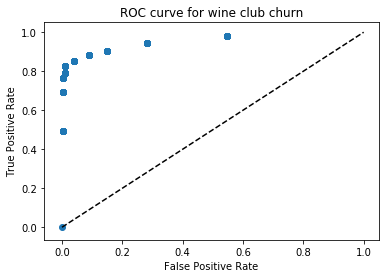

In [19]:
auc = cm.get_roc_curve(probas[:,1],y_test)

In [20]:
ranked_features = zip(rf_columns,feature_importance)

In [21]:
for pair in ranked_features:
    print(pair)

('Age', 0.05481318065412577)
('isPickup', 0.006326795505453384)
('Transactions', 0.06681861599405624)
('Shipments', 0.0401825589146481)
('Quantity', 0.03631690381340942)
('Orders Total', 0.032304693340685704)
('ASP', 0.020078099699216093)
('LTV', 0.07506395073310765)
('Time Since Last Order', 0.4022853927218274)
('Last Order Amount', 0.10647318494523399)
('Club Length', 0.09121821992893576)
('Average Transaction', 0.05612663747433735)
('Quarter Case', 0.006326250879914984)
('Half Case', 0.004522236352107002)
('Full Case', 0.0011432790429411744)


In [22]:
auc

(0.9538511151091347,
 array([0.97885196, 0.97885196, 0.97885196, 0.97885196, 0.97885196,
        0.97885196, 0.97885196, 0.97885196, 0.97885196, 0.97885196,
        0.94561934, 0.94561934, 0.94561934, 0.94561934, 0.94561934,
        0.94561934, 0.94561934, 0.94561934, 0.94561934, 0.94561934,
        0.90634441, 0.90634441, 0.90634441, 0.90634441, 0.90634441,
        0.90634441, 0.90634441, 0.90634441, 0.90634441, 0.90634441,
        0.88217523, 0.88217523, 0.88217523, 0.88217523, 0.88217523,
        0.88217523, 0.88217523, 0.88217523, 0.88217523, 0.88217523,
        0.85196375, 0.85196375, 0.85196375, 0.85196375, 0.85196375,
        0.85196375, 0.85196375, 0.85196375, 0.85196375, 0.85196375,
        0.82477341, 0.82477341, 0.82477341, 0.82477341, 0.82477341,
        0.82477341, 0.82477341, 0.82477341, 0.82477341, 0.82477341,
        0.78851964, 0.78851964, 0.78851964, 0.78851964, 0.78851964,
        0.78851964, 0.78851964, 0.78851964, 0.78851964, 0.78851964,
        0.7673716 , 0.76737

In [24]:
m.get_pickle(cm.model)
cm_test = pickle.load('model.p')
cm_test.unpack_data('../test_set.csv')

In [ ]:
cm_test = pickle.load('model.p')

In [ ]:
cm_test.unpack_data('../test_set.csv')

**If a member has no orders in POS, it is plausible that they were a ClubOnSite and had their tastings waived, and did not buy bottles in the tasting room. It is also plausible that they joined online and have not visited the tasting room to buy bottles.**

In [7]:
clubs["Club Length"].mean()

1.7388229730891585

In [4]:
clubs[clubs["Club Status"]=="Active"]["Club Length"].mean()

2.023008241758242

In [26]:
data["OrderCompletedDate"].min(),data["OrderCompletedDate"].max()

('2015-09-12 14:38:46', '2019-03-16 19:16:18')

In [5]:
data.columns

Index(['OrderNumber', 'Customer Number', 'OrderCompletedDate', 'orderstatus', 'ordertype', 'BillCustomerNumber', 'ShipStateCode', 'BillBirthDate', 'ShipZipCode', 'BillCity', 'BillZipCode', 'isPickup', 'Quantity', 'ProductType', 'ProductSKU', 'originalPrice', 'Price', 'Total'], dtype='object')

In [11]:
clubs.shape

(4366, 16)

In [5]:
clubs.columns

Index(['Customer ID', 'Club Tier', 'State', 'Zip', 'Age', 'isPickup', 'Transactions', 'Shipments', 'Quantity', 'Orders Total', 'LTV', 'Time Since Last Order', 'Last Order Amount', 'Club Status', 'Club Length', 'Cancel Reason'], dtype='object')

In [6]:
clubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4366 entries, 0 to 4365
Data columns (total 16 columns):
Customer ID              4366 non-null int64
Club Tier                4366 non-null object
State                    4366 non-null object
Zip                      4366 non-null object
Age                      4366 non-null float64
isPickup                 4366 non-null bool
Transactions             4366 non-null float64
Shipments                4366 non-null int64
Quantity                 1201 non-null float64
Orders Total             1201 non-null float64
LTV                      4366 non-null float64
Time Since Last Order    4366 non-null float64
Last Order Amount        4366 non-null float64
Club Status              4365 non-null object
Club Length              4366 non-null float64
Cancel Reason            1826 non-null object
dtypes: bool(1), float64(8), int64(2), object(5)
memory usage: 550.0+ KB


In [2]:
path = '../club_members.csv'
clubs = pd.read_csv(path)

In [3]:
clubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4366 entries, 0 to 4365
Data columns (total 19 columns):
Club                                                         4366 non-null object
Club Status                                                  4358 non-null object
Customer Number                                              4366 non-null int64
Bill Birth Date                                              4026 non-null object
Bill City                                                    4361 non-null object
Bill State Code                                              4361 non-null object
Bill Zip                                                     4358 non-null object
Ship Birth Date                                              3986 non-null object
Ship City                                                    4360 non-null object
Ship State Code                                              4360 non-null object
Ship Zip                                                     4357 non-null

**These have full values**
```
Club                                                         4366 non-null object
Customer Number                                              4366 non-null int64
Signup Date                                                  4366 non-null object
Shipments (note that these don't necessarily mean orders)    4366 non-null int64
Lifetime Value                                               4366 non-null object
```

**Need to fill NaNs for**
```
Club Status (Done)                                                4358 non-null object
Bill Birth Date  (Done ---> "age")                                           4026 non-null object
Ship City     (Calistoga)                                               4360 non-null object
Ship State Code   (CA)                                           4360 non-null object
Ship Zip          (94515)                                          4357 non-null object
Pickup Location    (Done ---> "isPickup")                                          1213 non-null object
Cancel Date        (Done ---> "clubLength")                                          2071 non-null object
Cancel Reason      (Keep NaNs?)                                         1826 non-null object
Last Processed Date                                         3827 non-null object
Last Order Date                                              4344 non-null object
```

**Don't need**
```
Bill City                                                    4361 non-null object
Bill State Code                                              4361 non-null object
Bill Zip                                                     4358 non-null object
```

**CLEAN UP Clubs**

In [4]:
nans = ["Club Status","Bill Birth Date","Ship Birth Date","Ship City","Ship State Code","Ship Zip","Pickup Location","Cancel Date","Cancel Reason","Last Processed Date","Last Order Date"]
delete = ["Bill City","Bill State Code","Bill Zip"]
keep = ["Club","Customer Number","Signup Date","Shipments (note that these don't necessarily mean orders)","Lifetime Value"]


In [5]:
clubs = clubs[nans + keep]

In [6]:
clubs["ltv"] = [float( "".join((ltv[1:].split(","))) ) for ltv in clubs["Lifetime Value"]]

In [7]:
clubs.loc[clubs["Club Status"].isna() & clubs["Cancel Date"].isna(),"Club Status"] = "Active"

In [8]:
clubs.loc[clubs["Club Status"].isna() & ~clubs["Cancel Reason"].isna(),"Club Status"] = "Cancelled"

In [9]:
clubs.loc[ (clubs["Bill Birth Date"].isna() & ~clubs["Ship Birth Date"].isna()) , "Bill Birth Date"] = clubs["Ship Birth Date"]

In [10]:
clubs.loc[ (~clubs["Bill Birth Date"].isna() & clubs["Ship Birth Date"].isna()) , "Ship Birth Date"] = clubs["Bill Birth Date"]


In [11]:
clubs.loc[ (clubs["Bill Birth Date"].isna() ),"Bill Birth Date" ] = str(1/1/20)

In [12]:
clubs["age"] = np.array( [(2019-int("19" + "".join(bd[-2::]))) for bd in clubs[~clubs["Bill Birth Date"].isna()]
                        ["Bill Birth Date"] ])

In [13]:
clubs.loc[(clubs["age"]==99),"age"] = clubs.loc[~(clubs["age"]==99),"age"].values.mean()

In [14]:
clubs.loc[clubs["Ship City"].isna(),"Ship City"] = "Calistoga"
clubs.loc[clubs["Ship State Code"].isna(),"Ship State Code"] = "CA"
clubs.loc[clubs["Ship Zip"].isna(),"Ship Zip"] = "94515"

In [15]:
clubs["isPickup"] = ~clubs["Pickup Location"].isna()

In [16]:
clubs["cancel"] = np.array([str(cancel).split("/")[0::2] for cancel in clubs["Cancel Date"]])

In [43]:
clubs["signup"] = [list(str(signup).split("/")[0::2]) for signup in clubs["Signup Date"]]

In [41]:
clubs["clubLength"] = [(int(end[1]) - int(start[1])) +  ((( (int(end[0])+12) - int(start[0]) ) % 12  ) / 12 ) if (len(end)==2) else (19 - int(start[1])) +  ((( (3+12) - int(start[0]) ) % 12  ) / 12 ) for end,start in zip(clubs["cancel"],clubs["signup"]) ]


In [42]:
clubs.sample(15)

,Club Status,Bill Birth Date,Ship Birth Date,Ship City,Ship State Code,Ship Zip,Pickup Location,Cancel Date,Cancel Reason,Last Processed Date,...,Customer Number,Signup Date,Shipments (note that these don't necessarily mean orders),Lifetime Value,ltv,age,isPickup,cancel,signup,clubLength
3616,Cancelled,6/1/72,6/1/72,El Dorado Hills,CA,95762,Tank Garage Winery,3/9/19,Switched Club Level,2/4/19,...,33264,9/10/18,3,"$2,115.54",2115.54,47.0,True,"[3, 19]","[9, 18]",1.500000
2308,Active,3/30/64,3/30/64,Cheyenne,WY,82009,NaN,NaN,NaN,2/4/19,...,22809,9/23/17,8,"$1,454.75",1454.75,55.0,False,[nan],"[9, 17]",2.500000
2488,Cancelled,9/22/81,9/22/81,Redwood City,CA,94063,NaN,3/6/19,Cutting Expenses/Lost Job,2/4/19,...,23431,11/17/17,7,"$1,628.54",1628.54,38.0,False,"[3, 19]","[11, 17]",2.333333
4129,Active,6/25/89,6/25/89,san francisco,CA,94118,Tank Garage Winery,NaN,NaN,NaN,...,35804,1/19/19,0,$143.52,143.52,30.0,True,[nan],"[1, 19]",0.166667
2993,Cancelled,11/13/85,11/13/85,Overland Park,KS,66211,NaN,12/21/18,Cutting Expenses/Lost Job,12/3/18,...,25816,4/14/18,3,$518.86,518.86,34.0,False,"[12, 18]","[4, 18]",0.666667
1132,Cancelled,9/7/75,9/7/75,modesto,CA,95356,Tank Garage Winery,9/17/18,NaN,NaN,...,16881,7/22/18,0,"$1,947.44",1947.44,44.0,True,"[9, 18]","[7, 18]",0.166667
2433,Cancelled,10/29/76,10/29/76,San Francisco,CA,94111,Tank Garage Winery,7/10/18,Suspend Until Further Notice,7/9/18,...,23276,11/4/17,4,$825.33,825.33,43.0,True,"[7, 18]","[11, 17]",1.666667
2457,Cancelled,4/8/52,4/8/52,Estacada,OR,97023,NaN,2/5/18,Cutting Expenses/Lost Job,2/5/18,...,23346,11/10/17,2,$274.03,274.03,67.0,False,"[2, 18]","[11, 17]",1.250000
2945,Cancelled,11/30/87,11/30/87,San Francisco,CA,94117,Tank Garage Winery,11/30/18,Cutting Expenses/Lost Job,NaN,...,25654,10/27/18,0,$348.79,348.79,32.0,True,"[11, 18]","[10, 18]",0.083333
3656,Cancelled,3/15/83,3/15/83,arlington,VA,22206,NaN,12/10/18,NaN,12/3/18,...,33439,9/19/18,1,$503.72,503.72,36.0,False,"[12, 18]","[9, 18]",0.250000


**Make index**
```
Customer Number
```
**Potential Features**
```
hasMerch, timebetweenPurchases, ASP
```
**Filtering**
```
Cancel Reason "Switched Club Level"
```




In [45]:
path = '../customer_list.csv'
customers = pd.read_csv(path)

In [46]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32820 entries, 0 to 32819
Data columns (total 10 columns):
Customer No.              32820 non-null int64
City                      10620 non-null object
State                     10658 non-null object
Zip Code                  10923 non-null object
Number Of Transactions    32817 non-null float64
Lifetime Value            32820 non-null object
Last Order Date           20185 non-null object
Last Order Amount         32820 non-null object
Date Added                32820 non-null object
Last Modified Date        32820 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 2.5+ MB


**Combine Customers (POS data?) onto Club**

In [52]:
# customers["ltv"] = [float("".join((ltv[1:].split(","))) ) for ltv in customers["Lifetime Value"]]
clubs = clubs.merge(customers[['Customer No.','Number Of Transactions','Lifetime Value','Last Order Date','Last Order Amount']],how="left",left_on="Customer Number",right_on="Customer No.")
clubs.sample(10)

,Club Status,Bill Birth Date,Ship Birth Date,Ship City,Ship State Code,Ship Zip,Pickup Location,Cancel Date,Cancel Reason,Last Processed Date,...,age,isPickup,cancel,signup,clubLength,Customer No.,Number Of Transactions,Lifetime Value_y,Last Order Date_y,Last Order Amount
2668,Active,9/3/66,9/3/66,Cincinnati,OH,45244,NaN,NaN,NaN,2/4/19,...,53.0,False,[nan],"[1, 18]",1.166667,24284,8.0,"$1,281.88",2/4/19,$173.34
2989,Cancelled,3/14/85,3/14/85,Los Angeles,CA,90015,NaN,11/7/18,No Reason Given,9/24/18,...,34.0,False,"[11, 18]","[4, 18]",0.583333,25807,3.0,$340.92,9/24/18,$157.96
1325,Cancelled,11/5/93,11/5/93,Napa,CA,94558,Tank Garage Winery,4/30/17,Moved/Difficult to Receive Shipments,11/21/16,...,26.0,True,"[4, 17]","[10, 16]",1.500000,17922,3.0,$256.57,11/28/16,$15.12
3578,Active,9/29/85,9/29/85,Atlanta,GA,30307,NaN,NaN,NaN,2/4/19,...,34.0,False,[nan],"[9, 18]",1.500000,33146,7.0,$686.56,2/4/19,$176.42
4066,Cancelled,10/22/82,10/22/82,Daly City,CA,94015,NaN,1/2/19,Other,NaN,...,37.0,False,"[1, 19]","[12, 18]",1.083333,35541,2.0,$50.00,1/2/19,$50.00
2504,Active,10/9/60,10/9/60,san clemente,CA,92673,Tank Garage Winery,NaN,NaN,2/4/19,...,59.0,True,[nan],"[11, 17]",2.333333,23495,9.0,"$1,232.94",2/4/19,$154.44
1577,Cancelled,11/22/74,11/22/74,San Francisco,CA,94107,NaN,11/27/18,Joined Another Winery's Club,9/25/18,...,45.0,False,"[11, 18]","[2, 17]",1.750000,19586,8.0,"$1,104.03",9/25/18,$157.96
2276,Active,2/19/90,1/1/00,Kent,WA,98032,NaN,NaN,NaN,2/4/19,...,29.0,False,[nan],"[9, 17]",2.500000,22718,10.0,"$1,392.75",2/4/19,$178.20
1943,Cancelled,8/1/61,8/1/61,San Rafael,CA,94901,NaN,9/2/18,Switched Club Level,7/9/18,...,58.0,False,"[9, 18]","[6, 17]",1.250000,21282,11.0,"$2,133.40",12/3/18,$307.54
4055,Active,3/10/75,3/10/75,kirkland,WA,98033,NaN,NaN,NaN,2/4/19,...,44.0,False,[nan],"[12, 18]",1.250000,35484,4.0,$685.35,2/4/19,$178.20


In [54]:
path = '../order_history.csv'
data = pd.read_csv(path)

**Aggregate totals by custid**

In [63]:
data["Total"] = data["Quantity"] * data["Price"]
customer_orders = data.groupby("Customer Number").sum()[["Quantity","Total"]]

In [64]:
customer_orders = customer_orders[customer_orders["Total"]!=0]

**Join Quantities and Totals on clubs**

In [66]:
clubs = clubs.merge(customer_orders,how="left",left_on="Customer Number",right_on="Customer Number")

In [69]:
clubs.sample(10)

,Club Status,Bill Birth Date,Ship Birth Date,Ship City,Ship State Code,Ship Zip,Pickup Location,Cancel Date,Cancel Reason,Last Processed Date,...,cancel,signup,clubLength,Customer No.,Number Of Transactions,Lifetime Value_y,Last Order Date_y,Last Order Amount,Quantity,Total
1486,Active,1/1/00,1/1/00,Union City,CA,94587,NaN,NaN,NaN,2/4/19,...,[nan],"[12, 16]",3.250000,18993,14.0,"$1,728.42",2/4/19,$172.44,NaN,NaN
1267,Cancelled,4/12/76,4/12/76,Novato,CA,94949,Tank Garage Winery,9/8/17,Cutting Expenses/Lost Job,11/21/16,...,"[9, 17]","[9, 16]",1.000000,17562,7.0,"$1,046.66",9/3/17,$126.07,38.0,1158.15
2157,Active,9/11/84,9/11/84,Petaluma,CA,94952,NaN,NaN,NaN,2/4/19,...,[nan],"[8, 17]",2.583333,22223,13.0,"$1,379.78",2/17/19,$31.03,NaN,NaN
64,Active,8/7/48,8/7/48,Conyers,GA,30012,NaN,NaN,NaN,2/4/19,...,[nan],"[8, 14]",5.583333,7745,25.0,"$5,072.00",2/4/19,$173.34,47.0,1855.80
833,Cancelled,8/21/77,8/21/77,niceville,FL,32578,NaN,9/30/16,No Reason Given,9/20/16,...,"[9, 16]","[2, 16]",0.583333,14690,3.0,$339.66,9/20/16,$162.00,12.0,301.50
2450,Active,7/13/87,7/13/87,Chicago,IL,60654,NaN,NaN,NaN,2/4/19,...,[nan],"[11, 17]",2.333333,23329,11.0,"$1,712.01",2/4/19,$172.13,NaN,NaN
1616,Cancelled,8/9/72,8/9/72,Moraga,CA,94556,NaN,1/29/19,Switched Club Level,12/3/18,...,"[1, 19]","[12, 17]",2.083333,19712,22.0,"$3,584.73",2/4/19,$143.48,NaN,NaN
2173,Active,2/7/91,1/1/90,Houston,TX,77019,NaN,NaN,NaN,2/4/19,...,[nan],"[8, 17]",2.583333,22301,11.0,"$1,627.01",2/8/19,$31.66,NaN,NaN
2627,Active,11/28/88,11/28/88,Anchorage,AK,99507,NaN,NaN,NaN,2/4/19,...,[nan],"[1, 18]",1.166667,24112,7.0,"$1,090.97",2/4/19,$198.50,NaN,NaN
3184,Cancelled,8/20/73,8/20/73,Wichita,KS,67204-1852,NaN,7/3/18,Testing/Accident,NaN,...,"[7, 18]","[6, 18]",0.083333,27838,13.0,"$2,374.86",2/19/19,$86.54,NaN,NaN


In [55]:
data.head(10)

,OrderNumber,Customer Number,OrderCompletedDate,orderstatus,ordertype,BillCustomerNumber,ShipStateCode,BillBirthDate,ShipZipCode,BillCity,BillZipCode,isPickup,Quantity,ProductType,ProductSKU,originalPrice,Price
0,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,1,Wine,44.15.750.TK.RB.TE,45.0,31.5
1,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,1,Product,CL.HT.3200.BK,20.0,14.0
2,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,2,Wine,47.15.750.TK.RB.LYS,50.0,35.0
3,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,5,Product,TK.GC,0.0,0.0
4,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,2,Wine,44.14.750.TK.CS.RB,55.0,38.5
5,48788,1008,2017-09-23 15:42:57,Completed,POS,NaN,CA,NaN,94515,Calistoga,94515,True,4,Product,TK.GCIN,0.0,0.0
6,104967,5002,2019-03-14 18:43:46,Completed,Promo,5002.0,CA,1920-01-01,94515,Calistoga,94515,True,1,Wine,78.17.750.TK.DFH.RW,60.0,0.0
7,104967,5002,2019-03-14 18:43:46,Completed,Promo,5002.0,CA,1920-01-01,94515,Calistoga,94515,True,1,Wine,85.16.750.TK.LN.RW,40.0,0.0
8,104033,5002,2019-03-01 17:53:22,Completed,Promo,5002.0,CA,1920-01-01,94515,Calistoga,94515,True,1,Wine,85.16.750.TK.LN.RW,40.0,0.0
9,103858,5002,2019-02-27 18:35:11,Completed,POS,5002.0,CA,1920-01-01,94515,Calistoga,94515,True,1,Wine,85.16.750.TK.LN.RW,40.0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65499 entries, 0 to 65498
Data columns (total 17 columns):
OrderNumber           65499 non-null int64
Customer Number       65499 non-null int64
OrderCompletedDate    65499 non-null object
orderstatus           65499 non-null object
ordertype             65499 non-null object
BillCustomerNumber    64609 non-null float64
ShipStateCode         65356 non-null object
BillBirthDate         44781 non-null object
ShipZipCode           65356 non-null object
BillCity              53068 non-null object
BillZipCode           53267 non-null object
isPickup              65499 non-null bool
Quantity              65499 non-null int64
ProductType           65499 non-null object
ProductSKU            65499 non-null object
originalPrice         65499 non-null float64
Price                 65499 non-null float64
dtypes: bool(1), float64(3), int64(3), object(10)
memory usage: 8.1+ MB


**Cells with NaNs**
```
BillCustomerNumber    64609 non-null float64
ShipStateCode         65356 non-null object
BillBirthDate         44781 non-null object
ShipZipCode           65356 non-null object
BillCity              53068 non-null object
BillZipCode           53267 non-null object
```

In [10]:
( data[data["BillCustomerNumber"].isna()]["Quantity"]*data[data["BillCustomerNumber"].isna()]["Price"] ).sum()

21163.519999999997

In [11]:
( data[~data["BillCustomerNumber"].isna()]["Quantity"]*data[~data["BillCustomerNumber"].isna()]["Price"] ).sum()

2552475.26